In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import statsmodels.api as sm
from catboost import CatBoostRegressor
import lightgbm as lgb

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
data = pd.read_csv('output_data/8_final_with_climate_data.csv')
print(data.shape)
print(data.head(3))

(3040, 28)
                    grower farm           field  field_fvid        lat  \
0  Wisconsin Central Farms  WCF       1 Necedah       62992  44.057164   
1  Wisconsin Central Farms  WCF  13 Nepco N 1/2       62996  44.209406   
2  Wisconsin Central Farms  WCF      16 13th St       62999  44.100775   

         lng  year       tmin       tmax        gdd  ...  potato_proportion  \
0 -90.040412  2014  44.815974  83.173633  13.772113  ...                0.4   
1 -90.021382  2014  45.498328  79.713370  12.804045  ...                0.0   
2 -90.050524  2014  45.224964  82.761841  14.263578  ...                0.4   

   intensity_5y  tmin_annual  tmax_annual  annual_prcp  summer_tmin  \
0      0.028712        -30.9         31.0     3.098630         -4.7   
1      0.101801        -31.1         31.1     1.244492         -1.1   
2      0.070153        -30.9         31.0     1.244492         -4.7   

  summer_avg  summer_prcp  winter_avg  winter_tmax  
0  18.290083     3.366667  -12.111905

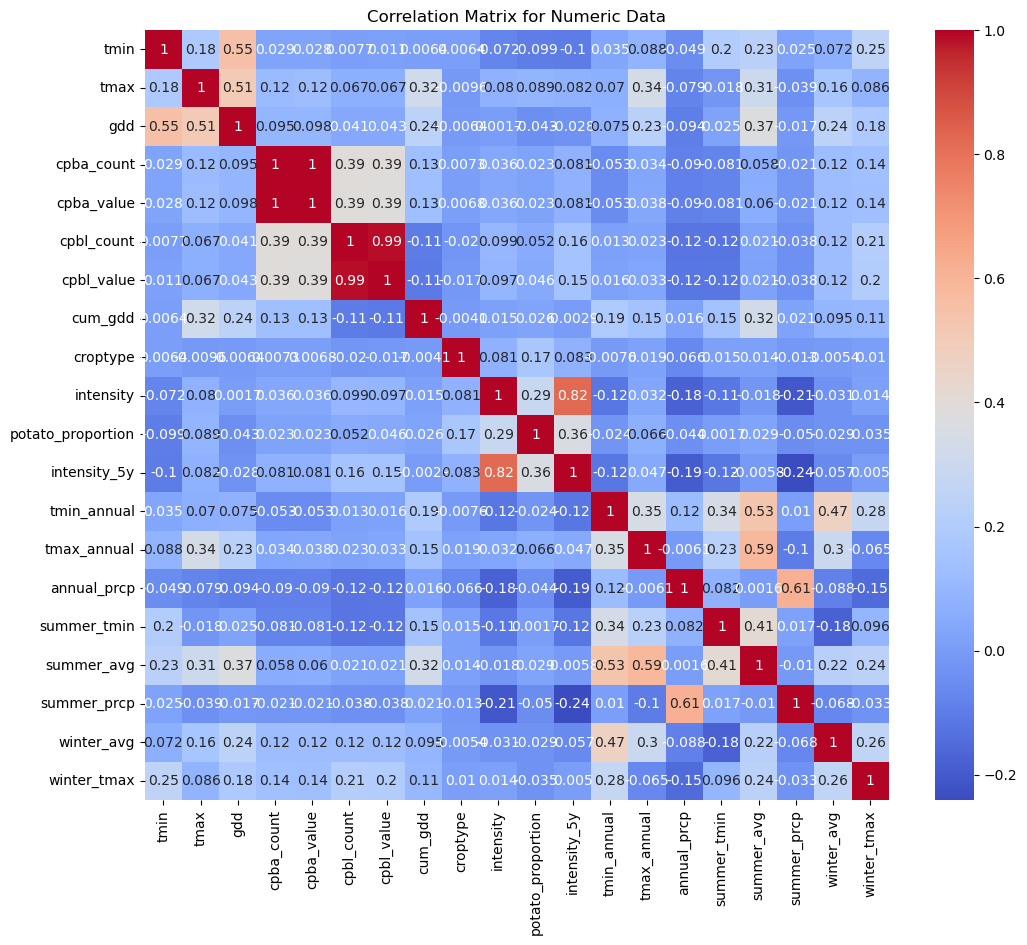

In [5]:
data_for_corr = data.drop(columns=['field_fvid','lat', 'lng', 'grower', 'field', 'farm', 'year'])
data = data_for_corr.select_dtypes(include=[float, int])

plt.figure(figsize=(12,10))
corr_mat = data.corr()
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Data')
plt.show()

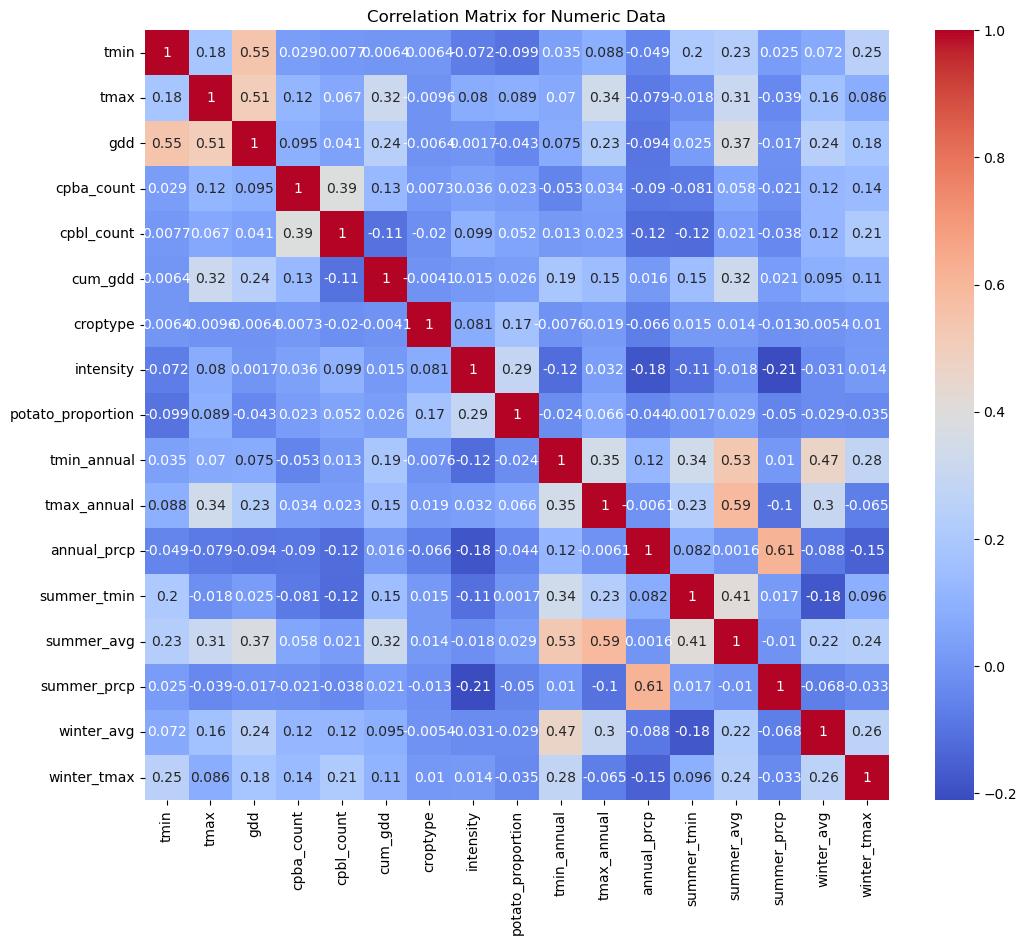

In [7]:
drop_list = ['cpba_value', 'cpbl_value',
            'intensity_5y']
data = data.drop(columns=drop_list)

plt.figure(figsize=(12,10))
corr_mat = data.corr()
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Data')
plt.show()

In [9]:
# Define X and y
data['y'] = (data['cpba_count'] + data['cpbl_count']) / 2  # Or use data['cpba_count']
X_high_corr = data.drop(columns=['cpba_count', 'cpbl_count', 'y'])
X = data.drop(columns=['cpba_count', 'cpbl_count', 'y', 'gdd', 'annual_prcp', 'summer_avg'])
y_combined = data['y']

X_high_corr_train, X_high_corr_test, y_train, y_test = train_test_split(X_high_corr, y_combined, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y_combined, test_size=0.2, random_state=42)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

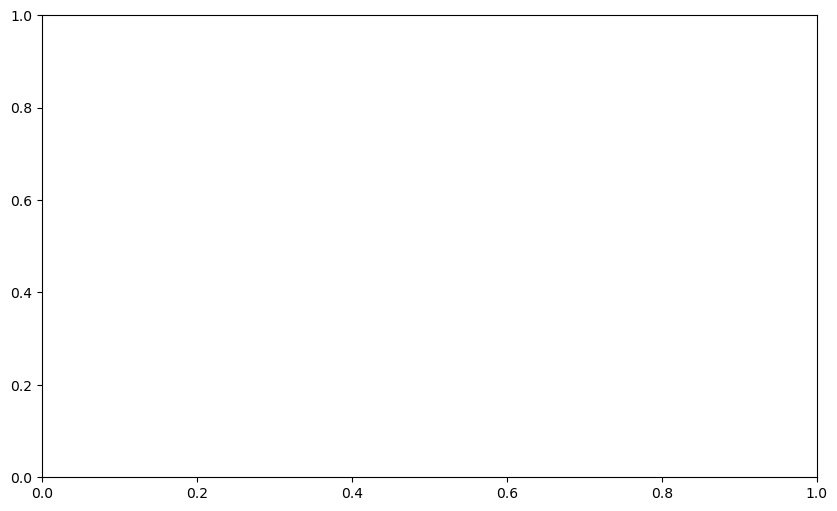

In [11]:
plt.figure(figsize=(10, 6)) 
sns.kdeplot(data['y'], fill=True, color='blue', alpha=0.6)

plt.title('Density Plot of Response Variable (y)', fontsize=14)
plt.xlabel('y', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.grid(True)  
plt.show()

In [13]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [17]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    """
    Train and evaluate a model on the given dataset.
    Returns: MSE and R2 scores
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}\n")
    
    return mse, r2

In [27]:
# Models for high-correlation dataset
models_high_corr = [
   # DecisionTreeRegressor(random_state=42),
   # RandomForestRegressor(n_estimators=100, random_state=42),
    XGBRegressor(objective='reg:squarederror', random_state=42),
   # GradientBoostingRegressor(random_state=42),
    lgb.LGBMRegressor(random_state=42),
    CatBoostRegressor(verbose=0, random_state=42)  # Silent training
]

# Models for no-correlation dataset
models_no_corr = [
  #  LinearRegression(),
  #  DecisionTreeRegressor(random_state=42),
   # RandomForestRegressor(n_estimators=100, random_state=42),
    XGBRegressor(objective='reg:squarederror', random_state=42),
    GradientBoostingRegressor(random_state=42),
    lgb.LGBMRegressor(random_state=42),
    CatBoostRegressor(verbose=0, random_state=42)  # Silent training
]

In [29]:
results = []

# Evaluate models for high-correlation dataset
print("Modeling for High-Correlation Dataset:")
for model in models_high_corr:
    mse, r2 = train_and_evaluate(model, X_high_corr_train, X_high_corr_test, y_train, y_test)
    results.append({"Dataset": "X_high_corr", "Model": model.__class__.__name__, "MSE": mse, "R2": r2})

# Evaluate models for no-correlation dataset
print("\nModeling for No-Correlation Dataset:")
for model in models_no_corr:
    mse, r2 = train_and_evaluate(model, X_train, X_test, y_train, y_test)
    results.append({"Dataset": "X", "Model": model.__class__.__name__, "MSE": mse, "R2": r2})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

Modeling for High-Correlation Dataset:
Model: XGBRegressor
Mean Squared Error: 2.6257
R2 Score: 0.2246

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 2432, number of used features: 15
[LightGBM] [Info] Start training from score 3.574579
Model: LGBMRegressor
Mean Squared Error: 2.5584
R2 Score: 0.2445

Model: CatBoostRegressor
Mean Squared Error: 2.3516
R2 Score: 0.3055


Modeling for No-Correlation Dataset:
Model: XGBRegressor
Mean Squared Error: 2.8583
R2 Score: 0.1559

Model: GradientBoostingRegressor
Mean Squared Error: 2.9279
R2 Score: 0.1354

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

In [31]:
# Unique models for high-correlation dataset
unique_high_corr_models = ["XGBRegressor", "LGBMRegressor", "CatBoostRegressor"]

# Unique models for no-correlation dataset
unique_no_corr_models = ["XGBRegressor", "GradientBoostingRegressor", "LGBMRegressor", "CatBoostRegressor"]

# Filter for unique high-correlation models
filtered_high_corr_importances = [
    entry for entry in filtered_importances_high_corr if entry["Model"] in unique_high_corr_models
]

# Filter for unique no-correlation models
filtered_no_corr_importances = [
    entry for entry in filtered_importances_no_corr if entry["Model"] in unique_no_corr_models
]

# Remove duplicates in case they appear in both filtered lists
seen_models = set()
filtered_high_corr_importances = [
    entry for entry in filtered_high_corr_importances if not (entry["Model"] in seen_models or seen_models.add(entry["Model"]))
]

seen_models = set()
filtered_no_corr_importances = [
    entry for entry in filtered_no_corr_importances if not (entry["Model"] in seen_models or seen_models.add(entry["Model"]))
]

# Print feature importances for high-correlation models
print("Feature Importances for High-Correlation Models:\n")
for entry in filtered_high_corr_importances:
    print(f"Model: {entry['Model']}")
    print("Feature Importance:")
    for feature, importance in zip(entry["Features"], entry["Feature Importances"]):
        print(f"{feature}: {importance:.4f}")
    print("-" * 40)



NameError: name 'filtered_importances_high_corr' is not defined

In [ ]:
# Print feature importances for no-correlation models
print("\nFeature Importances for No-Correlation Models:\n")
for entry in filtered_no_corr_importances:
    print(f"Model: {entry['Model']}")
    print("Feature Importance:")
    for feature, importance in zip(entry["Features"], entry["Feature Importances"]):
        print(f"{feature}: {importance:.4f}")
    print("-" * 40)

In [ ]:
# Define the models to include in the plots
high_corr_models = ["XGBRegressor", "LGBMRegressor", "CatBoostRegressor"]
no_corr_models = ["XGBRegressor", "GradientBoostingRegressor", "LGBMRegressor", "CatBoostRegressor"]

# Filter feature importances for the relevant models
filtered_importances_high_corr = [
    entry for entry in feature_importances if entry["Model"] in high_corr_models
]

filtered_importances_no_corr = [
    entry for entry in feature_importances if entry["Model"] in no_corr_models
]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances(feature_importances, n_rows, n_cols, title):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
    axes = axes.flatten()

    for i, entry in enumerate(feature_importances):
        features = entry["Features"]
        importances = entry["Feature Importances"]

        # Sort by importance
        sorted_idx = np.argsort(importances)[::-1]
        sorted_features = np.array(features)[sorted_idx]
        sorted_importances = np.array(importances)[sorted_idx]

        # Plot
        ax = axes[i]
        ax.barh(sorted_features, sorted_importances)
        ax.set_title(entry["Model"])
        ax.set_xlabel("Feature Importance")
        ax.invert_yaxis()

    # Adjust layout
    plt.suptitle(title, fontsize=16, y=0.92)
    plt.tight_layout()
    plt.show()

In [ ]:
for entry in filtered_importances_high_corr:
    # Check and fix mismatch
    if len(entry["Features"]) != len(entry["Feature Importances"]):
        min_length = min(len(entry["Features"]), len(entry["Feature Importances"]))
        entry["Feature Importances"] = entry["Feature Importances"][:min_length]

In [ ]:
for entry in filtered_importances_no_corr:
    # Check and fix mismatch
    if len(entry["Features"]) != len(entry["Feature Importances"]):
        min_length = min(len(entry["Features"]), len(entry["Feature Importances"]))
        entry["Feature Importances"] = entry["Feature Importances"][:min_length]

In [ ]:
plot_feature_importances(
    filtered_importances_high_corr,
    n_rows=1,
    n_cols=3,
    title="Feature Importances for High-Correlation Models"
)

In [ ]:
plot_feature_importances(
    filtered_importances_no_corr,
    n_rows=2,
    n_cols=2,
    title="Feature Importances for No-Correlation Models"
)

### Some other models like: GLM and GAM

In [ ]:
import statsmodels.api as sm

# Add a constant term for the intercept
X_glm = sm.add_constant(X_train)

# Fit a GLM model (Gaussian family)
glm_model = sm.GLM(y_train, X_glm, family=sm.families.Gaussian())
glm_results = glm_model.fit()

# Summarize results
print(glm_results.summary())

# Predict on the test set
X_test_glm = sm.add_constant(X_test)
y_pred_glm = glm_results.predict(X_test_glm)

# Evaluate
mse_glm = mean_squared_error(y_test, y_pred_glm)
r2_glm = r2_score(y_test, y_pred_glm)
print(f"GLM MSE: {mse_glm:.4f}, R2: {r2_glm:.4f}")

In [ ]:
pip install pygam

In [ ]:
from pygam import LinearGAM, s

# Fit a GAM model
gam = LinearGAM(s(0) + s(1) + s(2))  # Adjust for the number of continuous predictors
gam.fit(X_train.values, y_train)

# Summary of the model
print(gam.summary())

# Predict on the test set
y_pred_gam = gam.predict(X_test.values)

# Evaluate
mse_gam = mean_squared_error(y_test, y_pred_gam)
r2_gam = r2_score(y_test, y_pred_gam)
print(f"GAM MSE: {mse_gam:.4f}, R2: {r2_gam:.4f}")